# Kalman FilterによるARMAモデル時系列の推定

## 関連
- `state_system.ipynb`

In [42]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('./module')
from kalman_filters import ExtendedKalmanFilter as EnKF

np.random.seed(0)

In [128]:
def generate_state_data(F, G, q, x_0, size):
    """
    モデルノイズは1次元を仮定
    """
    data = np.zeros((size, len(x_0)))
    x = x_0
    data[0] = x
    for i in range(1, size):
        x = F@x + G@np.random.normal(loc=0, scale=q, size=(1,))
        data[i] = x
    return data

def generate_obs_data(H, r, series, noise=True):
    """
    観測ノイズは1次元を仮定
    """
    obs = (H@series.T).T
    if noise:
        obs += np.random.normal(loc=0, scale=r, size=(len(series),1))
    return obs 

# ARMAモデルによるデータの生成

In [175]:
# ARモデル
p = 3
a = np.array([-0.9, -0.7, -0.5]).reshape(p, 1)

# MAモデル
q = 3 
b = np.array([0.5, 0.5, 0.5])

N = max([p,q+1])
print(f'p = {p}, q = {q}, N = {N}')

# a, bを0拡張
if N > p:
    a_N = np.vstack([a, np.zeros(N-p)])
else:
    a_N = a

if N > q+1:
    b_N = np.hstack([b, np.zeros(N-q-2)])
else:
    b_N = b

# 状態遷移行列 (N, N)
F = np.block([a_N, np.vstack([np.eye(N-1), np.zeros((1, N-1))])])
print(f'F = \n{F}')

# ノイズ重み (N, 1), b_0=1を含む． 
G = np.array([1, *b_N]).reshape(N, 1)
print(f'G = \n{G}')

# 観測モデル (1, N)
H = np.block([1, np.zeros((1, N-1))])
print(f'H_ma = \n{H}')

# モデルノイズstd
sigma_m = 1
q = sigma_m
Q = np.array([q])
# 観測ノイズstd
sigma_o = 0.5
r = sigma_o
R = np.array([r])

p = 3, q = 3, N = 4
F = 
[[-0.9  1.   0.   0. ]
 [-0.7  0.   1.   0. ]
 [-0.5  0.   0.   1. ]
 [ 0.   0.   0.   0. ]]
G = 
[[1. ]
 [0.5]
 [0.5]
 [0.5]]
H_ma = 
[[1. 0. 0. 0.]]


In [176]:
# データを生成
sample_size = 100
x_0 = np.ones(N)
state_data = generate_state_data(F, G, Q, x_0, sample_size)
obs_data = generate_obs_data(H, R, state_data)
true = generate_obs_data(H, R, state_data, noise=False)

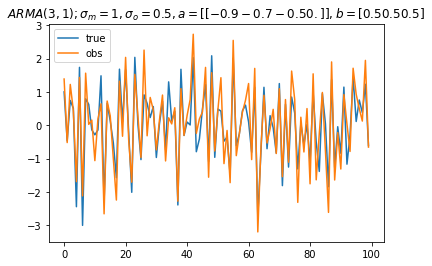

In [177]:
plt.plot(true, label='true')
plt.plot(obs_data, label='obs')
_ = plt.title(f'$ARMA({p},{q}); \sigma_m={sigma_m}, \sigma_o={sigma_o}, a={a_N.T}, b={b_N.T}$')
plt.legend()

In [191]:
import numpy as np
from numpy import sqrt, trace, zeros, identity, exp, random
from numpy.random import multivariate_normal, choice
from numpy.linalg import inv
import scipy
from scipy.linalg import sqrtm

# # TODO: import改良
# import sys
# sys.path.append('./module')
# from kalman_filters import ExtendedKalmanFilter

# ============================
# Extended Kalman Filter
# ============================
"""
TODO: 説明
状態空間モデル
x[t] = M(x[t-1]) + G(u[t])
y[t] = Hx[t-1] + w[t]
"""       
class ExtendedKalmanFilter:
    def __init__(self, M, H, G, Q, R, y, x_0, P_0, dt=0.05, delta=1e-3, var3d=False, alpha=1):
        self.M = M
        self.G = G
        self.H = H
        self.Q = Q
        self.R = R
        self.y = y
        self.dt = dt
        self.dim_x = x_0.shape[0]
        self.P = P_0
        self.trP = []
        self.x_a = x_0
        self.x = []
        self.delta = delta
        self.var3d = var3d
        #self.A = alpha*identity(dim_x) #　加法的誤差共分散膨張
        self.alpha = alpha # 1以上
        
  # 逐次推定を行う
    def forward_estimation(self):
        count = 0
        for y_obs in self.y:
            self._forecast()
            self._update(y_obs)

    # 更新/解析
    def _update(self, y_obs):
        # self.P = self.P + self.A # 加法的誤差共分散膨張, P = self.P + self.Aとするとうまくいかない． 乗法的方法に変更
        self.P = self.alpha*self.P # 乗法的
        P = self.P

        H = self.H.copy()
                
        # Kalman gain 
        K = P@H.T@inv(H@P@H.T + self.R)
        
        # 誤差共分散更新
        if not self.var3d:
            self.P -= K@H@P

        # x 更新
        self.x_a = self.x_f + K@(y_obs - H@self.x_f)

        # 更新した値を保存
        self.x.append(self.x_a)
        self.trP.append(sqrt(trace(self.P)/40)) # traceを正規化して保存

    # 予報/時間発展
    def _forecast(self, log=False):
        x_a = self.x_a; dt = self.dt; M = self.M; N = self.dim_x
        
        # 予報
        self.x_f = self.M(x_a, dt) + self._generate_noise() #保存しておく
        
        if not self.var3d:
            # 線形化， dtを大きくするとうまくいかなくなる
            JM = zeros((N, N))
            for j in range(N):
                dx = self.delta*identity(N)[:, j]
                JM[:, j] = (M(x_a + dx, dt) - self.x_f)/self.delta # ここでJM[:, j] = (M(x_a + dx, dt) - self.M(x_a, dt))/self.deltaとするとすごく遅くなる

            # self.P = JM@self.P@JM.T + self.G@self.Q@(self.G.T)
            self.P = JM@self.P@JM.T + self.Q[0]*self.G@(self.G.T)

        if log:
            self.x.append(self.x_f)
    
    def _generate_noise(self):
        if self.Q.shape[0] == 1:
            noise =  (self.G*np.random.normal(loc=0, scale=self.Q[0])).reshape(-1,)
            return noise
        else:
            return self.G@multivariate_normal(zeros(self.Q.shape[0]), self.Q)
    
    # 追加の推定(観測値なし)
    def additional_forecast(self, step):
        for _ in range(step):
            self._forecast(log=True)

In [192]:
M = lambda x,t: F@x
y = obs_data
x_0 = state_data[np.random.randint(0, sample_size)]
P_0 = 2*np.eye(N)
enkf = ExtendedKalmanFilter(M, H, G, Q, R, y, x_0, P_0, alpha=1.2)
enkf.forward_estimation()

estimate_data = generate_obs_data(H, R, np.array(enkf.x), noise=False)

0.5323461385208355

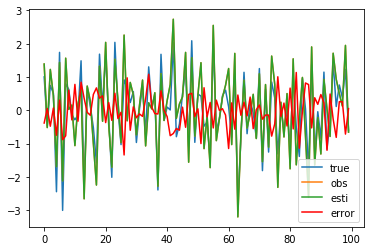

In [197]:
plt.plot(true, label='true')
plt.plot(obs_data, label='obs')
plt.plot(estimate_data, label='esti')
plt.plot(true - estimate_data, label='error', color='r')
plt.legend()

np.std(true - estimate_data)

観測データと同程度の誤差

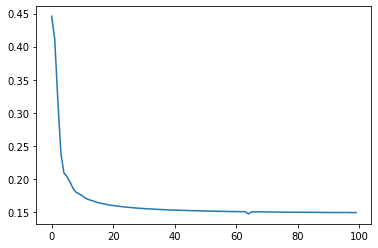

In [196]:
plt.plot(enkf.trP, label='true')